# Munging data with Pandas 


Data "munging" is the series of actions that we take to transform data that we are given from its raw form to something that we can process and understand. 

In neuroimaging, we can roughly divide this process into two steps: in the first, we work with the images that were collected in the scanner. This entails some image processing, some time-series analysis and so forth. In the second step, we might already be looking at features that have been extracted from the data and are abstracted away from the original images. For example, the size of each of a collection of brain regions in each of the subjects in a sample. The second kind of data can be organized into a *tabular* format. We will talk about desirable characteristics for this kind of data in a little bit, but let's start with a really simple example. Consider a dataset describing some fruit:

In [1]:
fruit = {"UID": ["a101", "o101", "o102", "b101"],
         "Kind": ["Apple", "Orange", "Orange", "Banana"], 
         "Price": [0.1, 0.75, 0.84, 1.2],
         "Weight": [200, 250, 280, 100],
         "Deliciousness": [8, 5, 6, 10]}

As a dictionary, these data would be hard to manipulate. For example, try writing code to display the average price of oranges. An altetnative would have been to store all this data as a Numpy array, but we also can't organize this very well into a numpy array, because it has mixed types and one dimension (the order of items in each list) means one thing, while the other (the different lists) means another thing. 

Pandas (sure, it's an animal, but it also stands for "panel data", which is another name for tabular data) is a software library that helps do exactly these kinds of things with data like this. Over the years, it's become a real "industry standard" for work with these kinds of data and has become a dependency or interoperates well with many other software libraries that analyze, visualize and create such data. Including many neuroscience-specific software. You will see some of these examples here, and once you learn about Pandas, will start noticing this everywhere.

Let's start by initializing a DataFrame, which is the workhorse object for Pandas data manipulations.

In [2]:
import pandas as pd

In [3]:
fruit_table = pd.DataFrame(fruit)

In Jupyter, we can show the data in nice tabular format: 

In [4]:
fruit_table

,UID,Kind,Price,Weight,Deliciousness
0,a101,Apple,0.10,200,8
1,o101,Orange,0.75,250,5
2,o102,Orange,0.84,280,6
3,b101,Banana,1.20,100,10


We can also use the DataFrame to query the data, either by column: 

In [5]:
fruit_table["Kind"]

0     Apple
1    Orange
2    Orange
3    Banana
Name: Kind, dtype: object

Or by designating one of our columns as an index:

In [6]:
fruit_table = fruit_table.set_index("UID")

In [7]:
fruit_table

,Kind,Price,Weight,Deliciousness
UID,,,,
a101,Apple,0.10,200,8
o101,Orange,0.75,250,5
o102,Orange,0.84,280,6
b101,Banana,1.20,100,10


and using that to query the rows: 

In [8]:
fruit_table.loc["a101"]

Kind             Apple
Price              0.1
Weight             200
Deliciousness        8
Name: a101, dtype: object

You can also combine these to query on rows and columns 

In [9]:
fruit_table.loc["a101", "Price"]

0.1

And even slice on each dimension to get sub-tables:

In [10]:
fruit_table.loc["a101":"o102", "Price":"Weight"]

,Price,Weight
UID,,
a101,0.10,200
o101,0.75,250
o102,0.84,280


There is another kind of indexer, `iloc` that will also give you a specific row based on its serial position in the table:

In [11]:
fruit_table.iloc[0]

Kind             Apple
Price              0.1
Weight             200
Deliciousness        8
Name: a101, dtype: object

But maybe you can already come up with some ideas about why using this kind of indexing can be a bad idea?

## Computing with DataFrame objects

Much like Numpy arrays, DataFrames have methods attached to them that let us do computations on the values stored in them. However, in contrast to Numpy arrays, averaging is typically (and per default) done column by column (because it wouldn't make sense to average price and weight, for example) and the DataFrame objects are aware of the fact that some of their columns may contain information that cannot be averaged, because it is not numeric.

In [12]:
fruit_table.mean(numeric_only=True)

Price              0.7225
Weight           207.5000
Deliciousness      7.2500
dtype: float64

We'll see other types of computations a bit further below, but let's 

## Selecting items in a DataFrame

One of the operations that we often want to do with data is to filter it or select based on a particular attribute. For example, we mentioned the idea of computing the average price of oranges in this dataset.

Let's parse this idea bit by bit. First, we'd like to find all the oranges in the `"Kind"` column. When we select a single column from the data, the return value is no longer a `DataFrame`. Instead, it's something that Pandas calls a `Series`

In [13]:
fruit_kinds = fruit_table["Kind"]

In [14]:
type(fruit_kinds)

pandas.core.series.Series

This kind of objects lends itself to Boolean operations. For example, comparisons:

In [15]:
is_orange = fruit_kinds == "Orange"

The result of this computation is another Pandas `Series` object, but this one has a Boolean datatype. 

In [16]:
is_orange

UID
a101    False
o101     True
o102     True
b101    False
Name: Kind, dtype: bool

In Numpy, we use Boolean arrays to index and select from other arrays of the same shape. In Pandas, we use Boolean Series to index and select on the rows of Pandas DataFrame objects. For example, the following gives us a table with only the Oranges from the original `fruit_table` DataFrame

In [17]:
fruit_table[is_orange]

,Kind,Price,Weight,Deliciousness
UID,,,,
o101,Orange,0.75,250,5
o102,Orange,0.84,280,6


We can also do this in one fell swoop, without creating the intermediate objects, and you will often see code that looks like this: 

In [18]:
orange_table = fruit_table[fruit_table["Kind"] == "Orange"]

 We can proceed to calculate the average price of oranges from the new table:

In [19]:
orange_table["Price"].mean()

0.7949999999999999

Or even in one call from the original table:

In [20]:
fruit_table[fruit_table["Kind"] == "Orange"]["Price"].mean()

0.7949999999999999

### Computing with Series

Because each Series does have a data type associated with it, you can do pretty sensible computations with it, such as multiplication by a scalar. For example, if we know that the "Weight" column is given in grams, we can convert all of the weights to Kilogram:

In [21]:
weight_in_kg = fruit_table["Weight"] / 1000

In [22]:
weight_in_kg

UID
a101    0.20
o101    0.25
o102    0.28
b101    0.10
Name: Weight, dtype: float64

Interestingly, we can make that into a new column in the existing table: 

In [23]:
fruit_table["Weight_kg"] = fruit_table["Weight"] / 1000

In [24]:
fruit_table

,Kind,Price,Weight,Deliciousness,Weight_kg
UID,,,,,
a101,Apple,0.10,200,8,0.20
o101,Orange,0.75,250,5,0.25
o102,Orange,0.84,280,6,0.28
b101,Banana,1.20,100,10,0.10


And because they all have the same number of items, you can also do item-by-item computations between Series objects: 

In [25]:
fruit_table["Price_per_kg"] = fruit_table["Price"] / fruit_table["Weight_kg"]

In [26]:
fruit_table

,Kind,Price,Weight,Deliciousness,Weight_kg,Price_per_kg
UID,,,,,,
a101,Apple,0.10,200,8,0.20,0.5
o101,Orange,0.75,250,5,0.25,3.0
o102,Orange,0.84,280,6,0.28,3.0
b101,Banana,1.20,100,10,0.10,12.0


### Exercise: 

How would you compute a "deliciousness per dollar" index for these fruit?


### Accessing data stored in files 

One of Pandas real super powers is the ability to read data from multiple different sources. 

So long as the data is stored in a way that can be interpreted as a table, Pandas can probably read it. This includes all kinds of proprietary formats (such as xls and stata files), and also all kinds of binary formats (if you like that kind of thing, check out the parquet file format for some high-efficiency ways of storing really large tables). 

Here, we'll look at some data stored in standard, text-based formats. The data we will look at comes from the ABIDE2 dataset and was extracted for this paper: 

> Bethlehem, R.A.I., Seidlitz, J., Romero-Garcia, R. et al. A normative modelling approach reveals age-atypical cortical thickness in a subgroup of males with autism spectrum disorder. Commun Biol 3, 486 (2020). https://doi.org/10.1038/s42003-020-01212-9

ABIDE2 is a large data collection and sharing effort focused on measurements from individuals with autism and control subjects. Let's see what we get when we read the tsv file that contains ABIDE data:

In [27]:
features = pd.read_csv("/home/jovyan/shared/abide2/abide2.tsv", sep="\t")

In [28]:
features.shape

(1004, 1446)

In [29]:
features

,site,subject,age,age_resid,sex,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,ABIDEII-KKI_1,29293,8.893151,13.642852,2.0,1.0,2750.0,306.0,354.0,2123.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,ABIDEII-OHSU_1,28997,12.000000,16.081732,2.0,1.0,2836.0,186.0,354.0,2261.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,ABIDEII-GU_1,28845,8.390000,12.866264,1.0,2.0,3394.0,223.0,373.0,2827.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,ABIDEII-NYU_1,29210,8.300000,13.698139,1.0,1.0,3382.0,266.0,422.0,2686.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,ABIDEII-EMC_1,29894,7.772758,14.772459,2.0,2.0,3080.0,161.0,346.0,2105.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,ABIDEII-IU_1,29570,20.000000,10.644232,1.0,2.0,3321.0,290.0,381.0,2802.0,...,2.553,3.502,2.955,2.873,3.074,2.849,2.941,2.863,2.854,3.265
1000,ABIDEII-NYU_1,29233,10.862000,16.260139,1.0,2.0,2860.0,162.0,456.0,2460.0,...,2.437,3.658,2.537,2.482,3.425,2.819,3.304,2.688,3.200,3.086
1001,ABIDEII-SDSU_1,28862,11.200000,13.211420,1.0,2.0,3377.0,177.0,497.0,2810.0,...,2.770,3.422,2.925,3.028,3.285,2.717,3.073,2.899,3.029,3.292
1002,ABIDEII-KKI_1,29312,9.789041,14.538742,2.0,2.0,3322.0,297.0,426.0,2640.0,...,2.579,3.328,2.998,3.062,3.601,3.049,2.901,2.704,3.076,3.114


The table contains 1004 rows, corresponding to the 1004 subjects in the dataset. 

The six first columns contain information about each subject: a unique identifier, their age, age residuals relative to the site from which their data was collected (which we will not use here, but will come in handy later in the week, when we use it in the machine learning session), their sex, and whether they were diagnosed with autism (where 1 indicates an autism diagnosis and 2 indicates a control subject). 

The remaining 1440 columns contain structural brain features computed with Freesurfer: surface area (fsArea), volume (fsVol), cortical thickness (fsCT), and local gyrification (fsLGI). We have 360 * 4 features, for each of the 360 regions-of-interest in the Human Connectome Project’s multi-modal parcellation.

When data are this big, it's sometimes useful to get a summary of the distributions of each column:

In [30]:
features.describe()

,subject,age,age_resid,sex,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.00000,...,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,29278.616534,15.101264,15.102124,1.238048,1.538845,3161.415339,226.266932,395.445219,2613.914343,1747.64741,...,2.543007,3.256986,2.677017,2.721997,3.173171,2.809079,3.051686,2.691974,2.867733,3.200925
std,374.424343,9.433702,5.363841,0.426101,0.498737,495.962723,68.517782,67.150610,343.635256,235.02218,...,0.346484,0.470978,0.317000,0.337975,0.323499,0.330795,0.375022,0.322569,0.351564,0.394258
min,28675.000000,5.128000,-5.390924,1.000000,1.000000,1423.000000,80.000000,166.000000,981.000000,791.00000,...,1.633000,1.682000,1.563000,1.652000,1.935000,1.399000,1.599000,1.647000,1.790000,1.138000
25%,28974.750000,9.280137,13.215053,1.000000,1.000000,2846.750000,172.000000,352.000000,2433.000000,1603.00000,...,2.309750,3.004000,2.487500,2.507000,2.987750,2.601250,2.835750,2.490000,2.640000,2.957500
50%,29247.500000,11.667580,14.909247,1.000000,2.000000,3136.500000,225.000000,396.500000,2619.000000,1746.50000,...,2.525500,3.357500,2.693500,2.724000,3.206000,2.852500,3.085500,2.709000,2.883500,3.221000
75%,29542.250000,18.015000,16.620996,1.000000,2.000000,3454.250000,275.000000,438.250000,2822.000000,1900.25000,...,2.784500,3.594250,2.883000,2.953250,3.389250,3.027250,3.313000,2.895000,3.097500,3.458000
max,30167.000000,64.000000,44.644232,2.000000,2.000000,4740.000000,494.000000,641.000000,3588.000000,2477.00000,...,3.448000,4.219000,3.735000,3.795000,4.136000,3.630000,4.083000,3.990000,3.961000,4.328000


In this case, we get some interesting information primarily about the age of the subjects. We also get a sense of the distribution among the two classes in `group` (is this data balanced?), but there are still a lot of columns to look at. Without worry about that too much for now, let's proceed to demonstrate some additional useful data management patterns accessible through Pandas.

## Split-apply-combine

This pattern is very common and very useful. The idea is that we can split the data based on some feature, apply some kind of computation to each group and then combine all of the results into a new dataset. 

For example, a pretty obvious thing to do here would be to split or group the data by the `group` variable, and compute some statistics separately for each one of the groups. We could do this based on what we've seen so far -- logical indexing that selects one group after the other and does the operations we want to do on each group separately. But let's introduce a new way of doing this and some new functionality. 

### Groupby

Each DataFrame object has a method `groupby`, which splits the data up internally according to the unique values of a column, or combination of columns. For example, we can ask the DataFrame to give us groups based on the `group` column:

In [31]:
autism_groups = features.groupby("group")

The resulting object is not a DataFrame! Instead, it's an object that is a little bit inscrutable. 

In [32]:
autism_groups

To make it more sensible, we have to keep going for a bit more. We've split the data. Next, we can apply a computation and combine back into a new dataset

In [33]:
autism_groups.mean()

,subject,age,age_resid,sex,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,fsArea_L_V4_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
group,,,,,,,,,,,,,,,,,,,,,
1.0,29273.377970,15.037286,14.739884,1.149028,3126.457883,223.701944,394.982721,2602.421166,1751.032397,1301.207343,...,2.547566,3.194184,2.658570,2.714605,3.166724,2.779883,3.046786,2.685890,2.853544,3.171564
2.0,29283.099815,15.156017,15.412138,1.314233,3191.332717,228.462107,395.841035,2623.750462,1744.750462,1295.454713,...,2.539105,3.310734,2.692804,2.728323,3.178689,2.834065,3.055880,2.697181,2.879876,3.226054


This result is a DataFrame! And now, instead of individuals on each row, it has reduced the data down to means across each group. 

What if we want to explore more complex combinations? For example, all possible combinations of `group` and `sex`? This would already be pretty cumbersome using Series indexing that we saw above. But `groupby` makes it relatively straightforward:
 

In [34]:
autism_sex_groups = features.groupby(["group", "sex"])

In [35]:
autism_sex_means = autism_sex_groups.mean()

In [36]:
autism_sex_means

subject        age  age_resid  fsArea_L_V1_ROI  \
group sex                                                        
1.0   1.0  29265.319797  15.267803  14.618591      3159.436548   
      2.0  29319.391304  13.720997  15.432485      2938.144928   
2.0   1.0  29275.458221  15.950980  15.509991      3271.962264   
      2.0  29299.776471  13.421129  15.198587      3015.370588   

           fsArea_L_MST_ROI  fsArea_L_V6_ROI  fsArea_L_V2_ROI  \
group sex                                                       
1.0   1.0        225.895939       397.809645      2628.096447   
      2.0        211.173913       378.840580      2455.811594   
2.0   1.0        234.261456       404.695418      2693.908356   
      2.0        215.805882       376.517647      2470.641176   

           fsArea_L_V3_ROI  fsArea_L_V4_ROI  fsArea_L_V8_ROI  ...  \
group sex                                                     ...   
1.0   1.0      1772.299492      1318.281726       262.827411  ...   
      2.0      1629.594203      1203.710145       241.768116  ...   
2.0   1.0      1801.854447      1340.859838       271.727763  ...   
      2.0      1620.129412      1196.364706       249.488235  ...   

           fsCT_R_p47r_ROI  fsCT_R_TGv_ROI  fsCT_R_MBelt_ROI  \
group sex                                                      
1.0   1.0         2.530772        3.212967          2.641046   
      2.0         2.643464        3.086928          2.758638   
2.0   1.0         2.515431        3.305202          2.678655   
      2.0         2.590771        3.322806          2.723682   

           fsCT_R_LBelt_ROI  fsCT_R_A4_ROI  fsCT_R_STSva_ROI  fsCT_R_TE1m_ROI  \
group sex                                                                       
1.0   1.0          2.710145       3.151109          2.777508         3.037480   
      2.0          2.740072       3.255884          2.793449         3.099928   
2.0   1.0          2.712925       3.168256          2.816326         3.042178   
      2.0          2.761929       3.201459          2.872776         3.085782   

           fsCT_R_PI_ROI  fsCT_R_a32pr_ROI  fsCT_R_p24_ROI  
group sex                                                   
1.0   1.0       2.685376          2.851764        3.162322  
      2.0       2.688826          2.863710        3.224333  
2.0   1.0       2.690836          2.869784        3.203434  
      2.0       2.711029          2.901900        3.275418  

[4 rows x 1443 columns]

The new object we get as a result of this computation is a DataFrame, but instead of one index that we can use to select from it, it has multiple levels of indexing (This is called a `MultiIndex`). The first one selects from the `group`:

In [37]:
autism_sex_means.loc[1]

,subject,age,age_resid,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,fsArea_L_V4_ROI,fsArea_L_V8_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
sex,,,,,,,,,,,,,,,,,,,,,
1.0,29265.319797,15.267803,14.618591,3159.436548,225.895939,397.809645,2628.096447,1772.299492,1318.281726,262.827411,...,2.530772,3.212967,2.641046,2.710145,3.151109,2.777508,3.037480,2.685376,2.851764,3.162322
2.0,29319.391304,13.720997,15.432485,2938.144928,211.173913,378.840580,2455.811594,1629.594203,1203.710145,241.768116,...,2.643464,3.086928,2.758638,2.740072,3.255884,2.793449,3.099928,2.688826,2.863710,3.224333


And the second one selects from among the options in `sex`, so that we can (for example) look at sex differences separately in each `group`:

In [38]:
autism_sex_means.loc[1, 1] - autism_sex_means.loc[1, 2]

subject             -54.071507
age                   1.546806
age_resid            -0.813894
fsArea_L_V1_ROI     221.291621
fsArea_L_MST_ROI     14.722026
                       ...    
fsCT_R_STSva_ROI     -0.015942
fsCT_R_TE1m_ROI      -0.062448
fsCT_R_PI_ROI        -0.003450
fsCT_R_a32pr_ROI     -0.011946
fsCT_R_p24_ROI       -0.062011
Length: 1443, dtype: float64

In [39]:
autism_sex_means.loc[2, 1] - autism_sex_means.loc[2, 2]

subject             -24.318250
age                   2.529851
age_resid             0.311404
fsArea_L_V1_ROI     256.591676
fsArea_L_MST_ROI     18.455573
                       ...    
fsCT_R_STSva_ROI     -0.056450
fsCT_R_TE1m_ROI      -0.043604
fsCT_R_PI_ROI        -0.020194
fsCT_R_a32pr_ROI     -0.032116
fsCT_R_p24_ROI       -0.071984
Length: 1443, dtype: float64

## Combining data

Another functionality that Pandas implements that is very useful is the ability to merge different data based on shared variables. For example, the Freesurfer features that we saw above are taken from anatomical scans, and ABIDE also provides some quality information about these anatomical scans: 

In [40]:
anat_qc = pd.read_csv("/home/jovyan/shared/abide2/abide2_anat_qap.csv")

Looking at the statistics of these QC data is probably pretty useful

In [41]:
anat_qc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Site_ID               1359 non-null   object 
 1   Sub_ID                1359 non-null   int64  
 2   Session               1359 non-null   object 
 3   Series                1359 non-null   object 
 4   Unique_ID             1359 non-null   object 
 5   CNR                   1359 non-null   float64
 6   SNR                   1359 non-null   float64
 7   Qi1                   1359 non-null   float64
 8   EFC                   1359 non-null   float64
 9   Smoothness_of_Voxels  1359 non-null   float64
 10  FBER                  1359 non-null   float64
 11  Cortical Contrast     1359 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 127.5+ KB


We notice that there is a lot more data here. This might be because some subjects have more than one entry (for example, attended more than one session). We can cut that down by dropping duplicates on the subject ID column. In most cases, we'd need to verify that this command really is doing the right 

In [42]:
anat_qc = anat_qc.drop_duplicates("Sub_ID")

Now let's describe the data

In [43]:
anat_qc.describe()

,Sub_ID,CNR,SNR,Qi1,EFC,Smoothness_of_Voxels,FBER,Cortical Contrast
count,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000,1082.000000
mean,30023.828096,7.910525,15.853902,0.130297,0.433698,3.407123,971.560153,0.363961
std,3967.752806,2.949125,4.477575,0.082930,0.059585,0.735785,673.147352,0.050135
min,28675.000000,2.774116,5.890210,0.015219,0.300929,2.404120,44.207581,0.219213
25%,28974.250000,5.979947,12.206109,0.067414,0.394725,2.848064,429.975019,0.340304
50%,29276.500000,7.477629,15.452889,0.102814,0.430139,3.155073,800.977907,0.362988
75%,29567.750000,9.667275,19.136251,0.176092,0.465653,3.885736,1404.146645,0.388161
max,51315.000000,30.974446,31.212256,0.455825,0.695141,6.879572,3928.347851,0.714774


There's still a bit more data here than in the Freesurfer table, and this is something we can explore in a bit more detail. For now, let's move on. This is probably a good time to mention that we can directly visualize data from a DataFrame's `hist` method. We'll look at other visualization methods that take advantage of Pandas later in the week. 

array([[<AxesSubplot:title={'center':'SNR'}>,
        <AxesSubplot:title={'center':'CNR'}>]], dtype=object)

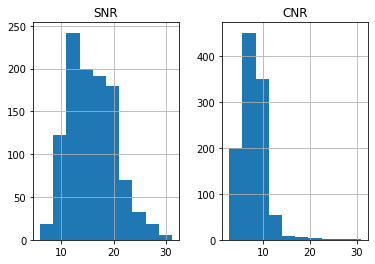

In [44]:
anat_qc[["SNR", "CNR"]].hist()

Let's say that we'd like to look at the Freesurfer information, but only for subjects that have an SNR larger than 10. One way to do that is to combine the data from the two tables. 

Before we do that, let's just note that there are few different ways that you could combine tables.

We'll go back to much simplified tables, before coming back to do this with the ABIDE data. Imagine we have some more fruit:

In [45]:
more_fruit = {"UID": ["a102", "a103", "o103", "b102"],
              "Kind": ["Apple", "Apple", "Orange", "Banana"], 
              "Price": [0.09, 0.125, 0.66, 3.0],
              "Weight": [180, 250, 220, 250],
              "Deliciousness": [3, 7, 10, 5]}

another_fruit_table = pd.DataFrame(more_fruit)
another_fruit_table = another_fruit_table.set_index("UID")

One way to combine these is to concatenate the tables. This can be useful for cases where more measurements are incrementally added to a dataset

In [46]:
pd.concat([fruit_table, another_fruit_table])

,Kind,Price,Weight,Deliciousness,Weight_kg,Price_per_kg
UID,,,,,,
a101,Apple,0.100,200,8,0.20,0.5
o101,Orange,0.750,250,5,0.25,3.0
o102,Orange,0.840,280,6,0.28,3.0
b101,Banana,1.200,100,10,0.10,12.0
a102,Apple,0.090,180,3,NaN,NaN
a103,Apple,0.125,250,7,NaN,NaN
o103,Orange,0.660,220,10,NaN,NaN
b102,Banana,3.000,250,5,NaN,NaN


Notice that Pandas is not too confused by the fact that these two tables have different numbers of columns, but it also doesn't automatically recompute the values for the table that doesn't have these added columns. 

This kind of combination would not be particularly useful for the ABIDE situation, is it? What do you think would happen if you concatenated the `features` and `anat_qc` tables in this way?

A more reasonable thing to do in this case is to *merge* the data. This is because the In a merge, we designate the variable that is used to merge (in databases, this is sometimes known as a "foreign key"). Here, we can rely on the fact that both tables have subject identifiers. 

In [47]:
merged = pd.merge(features, anat_qc, left_on="subject", right_on="Sub_ID")

The resulting table has information from both of the source tables. Note that `pd.merge` has different ways of merging data from different sources. What kinds of variations do you think we need to have for this operation? The `how` key-word argument of the merge function is a way to control different ways of doing this merge. Per default, it takes the strategy called an "inner" merge, which preserves only the cases where there is congruence between the keys. This also implies that we'll have the number of subjects of the smaller of the two (1004), dropping those subjects that appear in one table but not the other. This is the strategy that makes sense here, but sometimes you want to keep going with the subjects for whom you don't have data in some columns. In which case, another strategy might make more sense.

In [48]:
merged.describe()

,subject,age,age_resid,sex,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,...,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI,Sub_ID,CNR,SNR,Qi1,EFC,Smoothness_of_Voxels,FBER,Cortical Contrast
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.00000,...,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,29278.616534,15.101264,15.102124,1.238048,1.538845,3161.415339,226.266932,395.445219,2613.914343,1747.64741,...,2.867733,3.200925,29278.616534,7.804084,15.696344,0.130369,0.431336,3.403760,1007.250452,0.363549
std,374.424343,9.433702,5.363841,0.426101,0.498737,495.962723,68.517782,67.150610,343.635256,235.02218,...,0.351564,0.394258,374.424343,2.877876,4.464538,0.083182,0.058581,0.743931,674.194435,0.048705
min,28675.000000,5.128000,-5.390924,1.000000,1.000000,1423.000000,80.000000,166.000000,981.000000,791.00000,...,1.790000,1.138000,28675.000000,2.850605,5.890210,0.016703,0.300929,2.404120,44.207581,0.219804
25%,28974.750000,9.280137,13.215053,1.000000,1.000000,2846.750000,172.000000,352.000000,2433.000000,1603.00000,...,2.640000,2.957500,28974.750000,5.956347,12.147120,0.067471,0.392218,2.846448,456.045059,0.340342
50%,29247.500000,11.667580,14.909247,1.000000,2.000000,3136.500000,225.000000,396.500000,2619.000000,1746.50000,...,2.883500,3.221000,29247.500000,7.355427,15.275758,0.102370,0.428819,3.145281,859.740392,0.363179
75%,29542.250000,18.015000,16.620996,1.000000,2.000000,3454.250000,275.000000,438.250000,2822.000000,1900.25000,...,3.097500,3.458000,29542.250000,9.560162,18.802411,0.174892,0.464870,3.893519,1441.885931,0.388853
max,30167.000000,64.000000,44.644232,2.000000,2.000000,4740.000000,494.000000,641.000000,3588.000000,2477.00000,...,3.961000,4.328000,30167.000000,30.974446,31.212256,0.455825,0.695141,6.879572,3928.347851,0.714774


Now, we can conduct the comparisons we want (e.g., grouping by `sex` and `group`) directly on the merged data, incorporating information about SNR as a selection variable. Putting together much of what we saw above, we can call: 

In [49]:
merged[merged["SNR"] > 10].groupby(["group", "sex"]).mean()

subject        age  age_resid  fsArea_L_V1_ROI  \
group sex                                                        
1.0   1.0  29269.377841  13.522359  14.446743      3175.482955   
      2.0  29319.391304  13.720997  15.432485      2938.144928   
2.0   1.0  29287.206997  14.182094  15.439277      3283.297376   
      2.0  29299.776471  13.421129  15.198587      3015.370588   

           fsArea_L_MST_ROI  fsArea_L_V6_ROI  fsArea_L_V2_ROI  \
group sex                                                       
1.0   1.0        228.821023       400.843750      2645.465909   
      2.0        211.173913       378.840580      2455.811594   
2.0   1.0        236.081633       405.163265      2695.723032   
      2.0        215.805882       376.517647      2470.641176   

           fsArea_L_V3_ROI  fsArea_L_V4_ROI  fsArea_L_V8_ROI  ...  \
group sex                                                     ...   
1.0   1.0      1782.517045      1332.474432       265.477273  ...   
      2.0      1629.594203      1203.710145       241.768116  ...   
2.0   1.0      1804.871720      1347.813411       272.830904  ...   
      2.0      1620.129412      1196.364706       249.488235  ...   

           fsCT_R_a32pr_ROI  fsCT_R_p24_ROI        Sub_ID       CNR  \
group sex                                                             
1.0   1.0          2.884960        3.191381  29269.377841  8.216626   
      2.0          2.863710        3.224333  29319.391304  8.140209   
2.0   1.0          2.888324        3.223222  29287.206997  7.977156   
      2.0          2.901900        3.275418  29299.776471  7.841148   

                 SNR       Qi1       EFC  Smoothness_of_Voxels         FBER  \
group sex                                                                     
1.0   1.0  16.102952  0.145316  0.442239              3.453664   811.968411   
      2.0  16.372066  0.136611  0.415023              3.242509   985.344554   
2.0   1.0  15.908691  0.134002  0.437344              3.333721  1047.758296   
      2.0  16.975128  0.120035  0.410199              3.069922  1184.363938   

           Cortical Contrast  
group sex                     
1.0   1.0           0.364790  
      2.0           0.365429  
2.0   1.0           0.370442  
      2.0           0.356588  

[4 rows x 1451 columns]

## Tidy data

A few more words before we wrap up. We saw here operations that we can do with input data using Pandas. This is all pretty elegant, and there's a lot more. But underlying our ability to perform these operations is a secret. The data have to show up looking a very particular way for all this to work. This way is sometimes called "Tidy data" after a concept described by the illustrious computational statistician and statistical software pioneer Hadley Wickham. In a paper called simply ["Tidy data"](https://vita.had.co.nz/papers/tidy-data.pdf) he describes the details of this idea, but it boils down to the idea that each row is an observation in our dataset and each column should be a variable. So, for example, a datset that has a column named "Subject_001" should raise some red flags. This is also something that database people call "Third normal form". There are some variations on this (we'll see a bit of these variations in the visualization tutorial), and some nuances (for example, a column called "is_male" or "is_autism" is much more useful than "sex" and "group"), but that's the big picture idea. Once everything is nice and tidy, Pandas can do a lot with it. 